In [40]:

import sys
import os
from typing import List, Dict, Tuple, Any

eval_folder_path = "exp/shadow_with_aug_selection_sasrec_on_sr_data_lr0.01_lstep20/0923_AmazonBeautyMAB_Thompson"
config_path = os.path.join(eval_folder_path, "config.yaml")
evaluation_log_path = os.path.join(eval_folder_path, "eval_results.log")
print_log_path = os.path.join(eval_folder_path, "exp_print.log")


In [41]:
def load_log_file(file_path : str) -> str:
    """
    Load the log file and return the content as string.
    """
    with open(file_path, 'r') as file:
        log_content = file.read()
    
    return log_content

In [44]:
import re
import numpy as np
import ast
## Parse exp_print.log for each experiment
""" Amazon Beauty
2024-09-21 17:40:02,316 (shadow_client_and_server:292) INFO: Controller Evaluation{Average_Reward : -8.465918, Action_Distribution : [0.333333 0.333333 0.333333 0.       0.       0.       0.       0.      ]}
2024-09-21 17:40:02,346 (shadow_client_and_server:153) INFO: ----------- Starting a new training round (Round #3) -------------
2024-09-21 17:40:02,348 (shadow_client_and_server:283) INFO: Augmentation Controll : 3
2024-09-21 17:40:02,348 (fed_runner:1223) INFO: Assigning data :{'proxy_client': 1, 'shadow_client': 14665}
2024-09-21 17:40:02,605 (shadow_client_and_server:857) INFO: {'Role': 'Client #14665', 'Round': 3, 'Results_raw': {'train_total': 20, 'train_loss': 148.382167, 'train_avg_loss': 7.419108, 'train_recall_10': 0.0, 'train_recall_20': 0.0, 'train_ndcg_10': 0.0, 'train_ndcg_20': 0.0}}
2024-09-21 17:40:02,606 (fed_runner:1223) INFO: Assigning data :{'proxy_client': 2, 'shadow_client': 5763}
"""
"""ML-1M
2024-09-21 17:44:03,604 (fed_runner:1223) INFO: Assigning data :{'proxy_client': 16, 'shadow_client': 4760}
2024-09-21 17:44:03,908 (shadow_client_and_server:857) INFO: {'Role': 'Client #4760', 'Round': 2, 'Results_raw': {'train_total': 20, 'train_loss': 165.767043, 'train_avg_loss': 8.288352, 'train_recall_10': 0.0, 'train_recall_20': 0.0, 'train_ndcg_10': 0.0, 'train_ndcg_20': 0.0}}
2024-09-21 17:44:03,920 (shadow_client_and_server:292) INFO: Controller Evaluation{Average_Reward : -8.295804, Action_Distribution : [0.333333 0.333333 0.333333 0.       0.       0.       0.       0.      ]}
2024-09-21 17:44:03,938 (shadow_client_and_server:153) INFO: ----------- Starting a new training round (Round #3) -------------
2024-09-21 17:44:03,939 (shadow_client_and_server:283) INFO: Augmentation Controll : 3
"""
"""
2024-09-23 21:49:19,846 (shadow_client_and_server:574) INFO: 'Controller Evaluation' : {'avg_reward' : -8.338225, 'action_distribution' : [0.166667 0.166667 0.166667 0.166667 0.166667 0.166667 0.       0.
 0.      ]}
 2024-09-23 21:49:19,873 (shadow_client_and_server:561)
 (shadow_client_and_server:1159)
"""
"""
2024-09-23 22:26:55,059 (shadow_client_and_server:576) INFO: Augmentation Controll : 2
2024-09-23 22:26:55,060 (fed_runner:1223) INFO: Assigning data :{'proxy_client': 1, 'shadow_client': 10298}
2024-09-23 22:26:55,326 (shadow_client_and_server:1174)
"""
def extract_controller_evaluation(text : str) -> List[int]:
    # Regex to extract avg_reward
    avg_reward_pattern = r"'avg_reward'\s*:\s*(-?\d+\.\d+)"
    
    # Regex to extract action_distribution, including potential line breaks
    action_dist_pattern = r"'action_distribution'\s*:\s*\[((?:[0-9.]+\s*)+)\]"

    # Extract avg_reward values
    avg_rewards = re.findall(avg_reward_pattern, text)
    avg_rewards = [float(ar) for ar in avg_rewards]  # Convert to float

    # Extract action_distribution values (handles line breaks)
    action_distributions = re.findall(action_dist_pattern, text)
    
    # Convert the space-separated values inside the brackets to numpy arrays
    action_distributions = [np.array([float(x) for x in dist.split()]) for dist in action_distributions]

    return avg_rewards, action_distributions
    
def extract_control(text : str) -> int:
    """
    Extract the flag from the text.
    """
    pattern = r"Augmentation Controll\s*:\s*(\d+)"
    match = re.search(pattern, text)
    if match:
    # Extract and convert Augmentation Controll to integer
        augmentation_controll = int(match.group(1))
        return augmentation_controll


def extract_reward(text : str) -> float:
    """
    Extract the reward from the text.
    """
    pattern = r"'train_avg_loss'\s*:\s*([\d.]+)"
    match = re.search(pattern, text)
    if match:
        reward = float(match.group(1))
        return reward

## Record Via Each Runs Later Divide by client sample size
augControls = np.zeros(9)
control_history = []
avgRewards = []
actionDistributions = []

## For getting MAB Bounds
rewards = [] ## Train Loss
mean_rewards_via_rounds = []

current_control = None
current_average_reward, current_action_distribution = None, None
for line in load_log_file(print_log_path).split("\n"):
    #if "(shadow_client_and_server:574)" in line:
    #    ## parse the list at the end
    #    current_average_reward, current_action_distribution = extract_controller_evaluation(line)
    #    avgRewards.append(current_average_reward)
    #    actionDistributions.append(current_action_distribution)

        
    if "(shadow_client_and_server:283)" in line or "(shadow_client_and_server:561)" in line or "(shadow_client_and_server:576)" in line:
        current_control = extract_control(line)
        augControls[current_control] += 1
        control_history.append(current_control)
    
    elif "(shadow_client_and_server:857)" in line or "(shadow_client_and_server:1159)" in line or "(shadow_client_and_server:1174)" in line:
        reward = extract_reward(line)
        rewards.append(reward)

## Divide by the number of clients
for i in range(0,len(rewards),16):
    round_rewards = rewards[i:i+16]
    mean_rewards_via_rounds.append(np.mean(round_rewards))

## Print the results
print("Augmentation Controls : ", augControls[:10])
print("Action Distributions : ", actionDistributions[:10])
print("Total Average Rewards : ", avgRewards[:10])
print("Mean Rewards via Rounds : ", mean_rewards_via_rounds[:10])

Augmentation Controls :  [6.212e+03 3.000e+00 5.923e+03 5.885e+03 5.870e+03 1.000e+00 1.000e+00
 6.104e+03 1.000e+00]
Action Distributions :  []
Total Average Rewards :  []
Mean Rewards via Rounds :  [7.746886437500001, 9.2722265625, 7.562471625000001, 8.055644000000001, 8.5208525625, 8.87136, 8.876472625, 7.952442875, 7.837401, 7.941990875]


(30, 9)


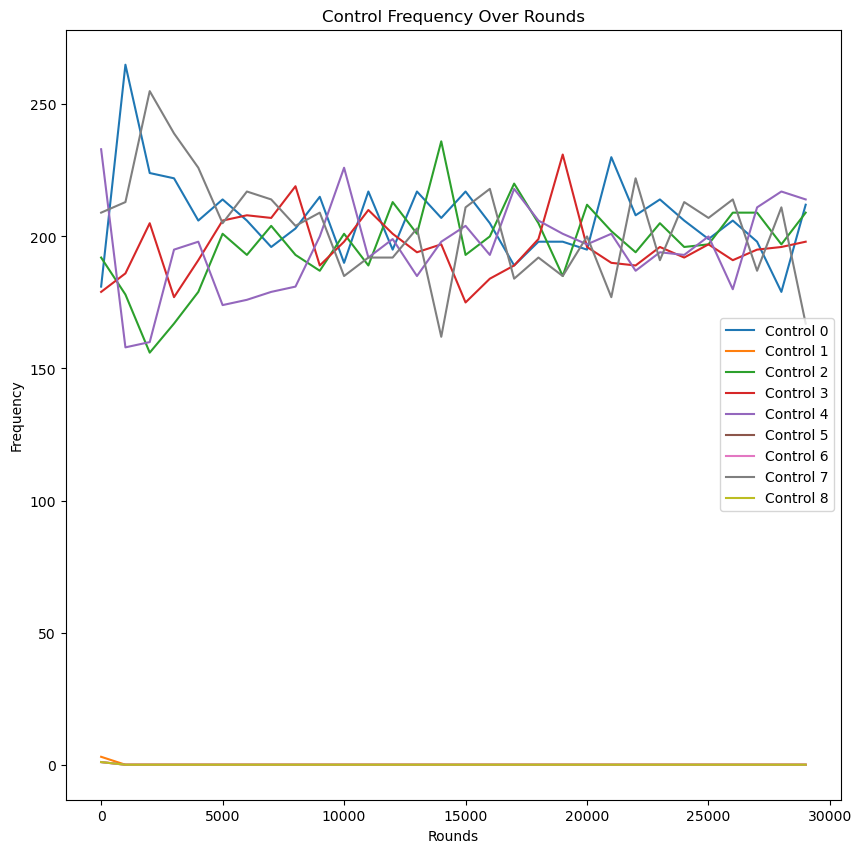

In [45]:
## in every 1000 rounds measure each control frequency (arm frequency)

import matplotlib.pyplot as plt

## count frequency every 1000 rounds
## plot histogram of control frequency
control_bins = []
rounds = []
for i in range(0,len(control_history),1000):
    control_bins.append(np.bincount(control_history[i:i+1000], minlength=9))
    rounds.append(i)

control_bins = np.array(control_bins)
print(control_bins.shape)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.plot(rounds, control_bins[:,i], label=f"Control {i}")
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Frequency")
plt.title("Control Frequency Over Rounds")
plt.show()


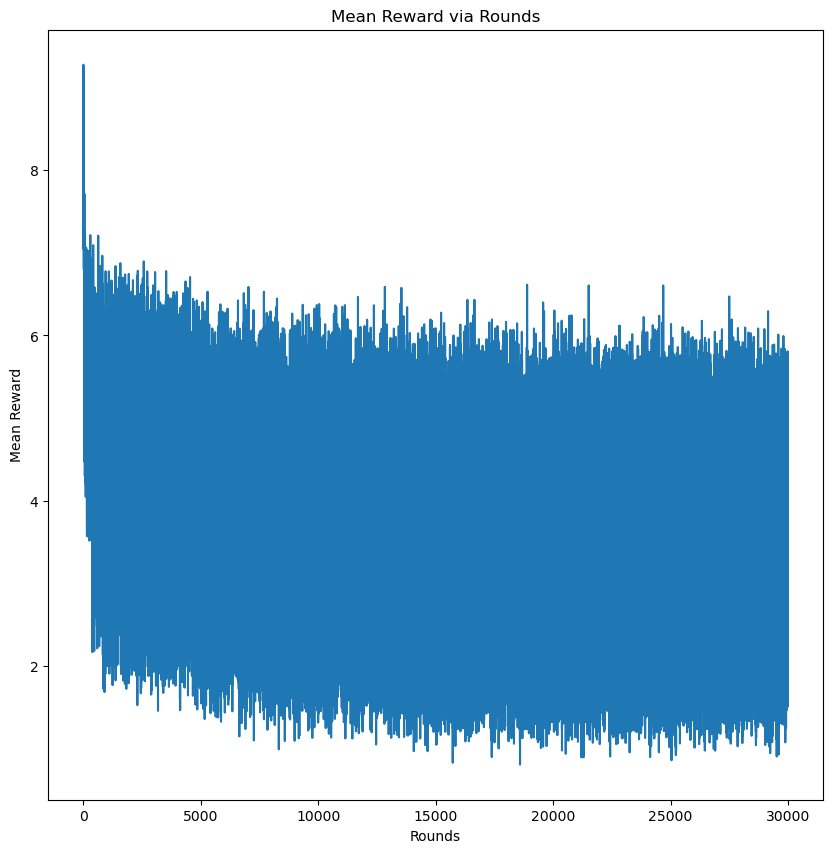

In [46]:
## Plot the rewards
plt.figure(figsize=(10,10))
plt.plot(mean_rewards_via_rounds)
plt.xlabel("Rounds")
plt.ylabel("Mean Reward")
plt.title("Mean Reward via Rounds")
plt.show()



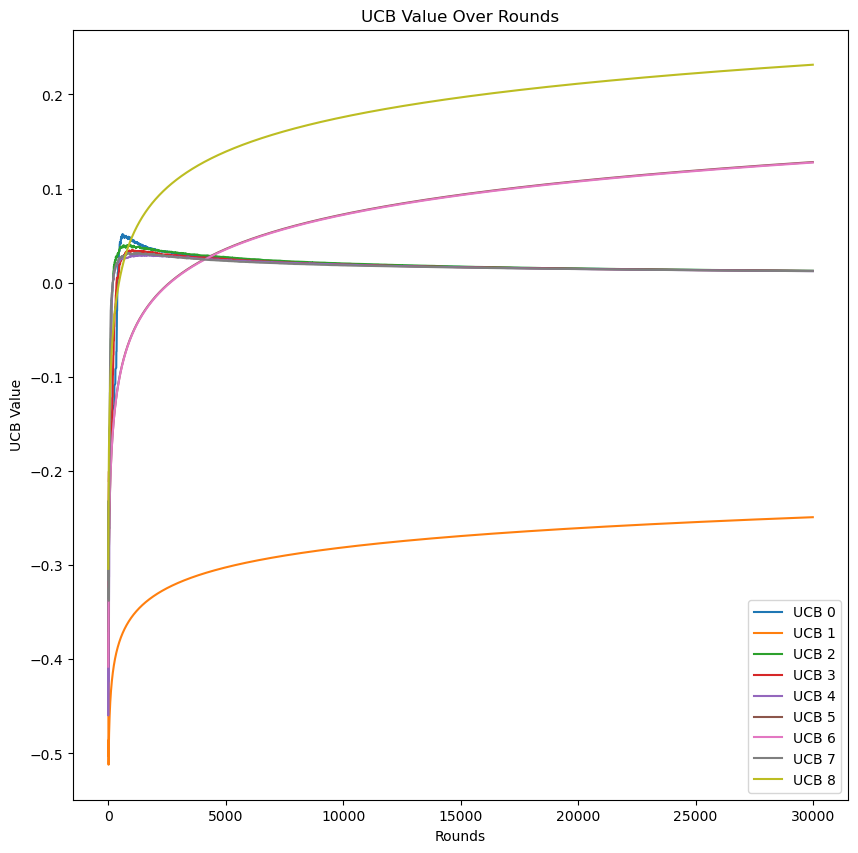

In [47]:
## After each round each rewards is appended to each arm.
## Plot the rewards for each arm


def ucb_calculate(reward_record, n_pull, alpha):
    
    ucb_values = np.zeros(len(reward_record))
    
    total_runs = np.sum(n_pull)
    for arm in range(len(reward_record)):
        avg_reward = reward_record[arm] / n_pull[arm]
        exploration = np.sqrt(alpha * np.log(total_runs) / n_pull[arm])
        ucb_values[arm] = avg_reward + exploration

    return ucb_values
    
reward_via_round = []
ucb_value_via_round = []

previous_reward_record = np.zeros(9)
previous_n_pulls = np.zeros(9)
decay = 0.9
alpha = 0.1
for round, (arm, reward) in enumerate(zip(control_history, mean_rewards_via_rounds)):
    
    reward = -reward ## convert
    
    new_n_pulls = previous_n_pulls.copy()
    new_n_pulls[arm] += 1
    
    updated_reward = previous_reward_record[arm] * decay + (1-decay) * reward
    new_reward_record = previous_reward_record.copy()
    new_reward_record[arm] = updated_reward
    reward_via_round.append(new_reward_record)
    if round > 8:
        ucb_values = ucb_calculate(new_reward_record, new_n_pulls, alpha)
        ucb_value_via_round.append(ucb_values)

    previous_reward_record = new_reward_record
    previous_n_pulls = new_n_pulls

## UCBS
ucb_value_via_round = np.array(ucb_value_via_round)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.plot(ucb_value_via_round[:,i], label=f"UCB {i}")
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("UCB Value")
plt.title("UCB Value Over Rounds")
plt.show()



In [32]:
## Arm Distribution over time
plt.figure(figsize=(10,10))
for i in range(8):
    plt.plot(np.array(actionDistributions)[:,i], label=f"Arm {i}")
plt.legend()
plt.xlabel("Rounds")
plt.title("Reward Distribution Over Rounds")
plt.show()




/tmp/ipykernel_3026209/2289635296.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(np.array(actionDistributions)[:,i], label=f"Arm {i}")


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 1000x1000 with 0 Axes>